In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import xarray as xr

In [2]:
#Replace with file path for this directory on your machine
!pip install -e /Users/justinmaynard/Documents/GitHub/assetraMP/ 

Obtaining file:///Users/justinmaynard/Documents/GitHub/assetraMP
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for assetra (pyproject.toml) ... done
  Created wheel for assetra: filename=assetra-1.0.3-py3-none-any.whl size=2689 sha256=dbec1acd386afa31ce06d71424f177f8781dc8432d27f26b9e6f1bc595d1c07a
  Stored in directory: /private/var/folders/zd/3zqsbnbn5lg29wjyl0df33l80000gn/T/pip-ephem-wheel-cache-8g5r7vym/wheels/c0/f5/c9/3b09bf7f2c6beadc5d6cde6ca7e50094804a4b90493c211e80
Successfully built assetra
  Attempting uninstall: assetra
    Found existing installation: assetra 1.0.3
    Uninstalling assetra-1.0.3:
      Successfully uninstalled assetra-1.0.3


In [3]:
p = Path(".")
root_folder = p.cwd().parent
root_folder
data_folder = root_folder / 'pjm_2023_test' / 'pjm_data'
data_folder
scripts_foler = root_folder/ 'pjm_2023_test'
gen_forecast_folder = data_folder / 'gen_forecasts'
outside_data_folder = data_folder / 'outside_data'

### Demand Data

In [4]:
#Function to load demand data
def load_pjm_cleaned_hourly_demand(
        pjm_demand_file: Path,
        start_hour: datetime,
        end_hour: datetime) -> xr.DataArray:
    """Return hourly demand data as formatted data array.
    To use this function, download cleaned demand data from:

    https://github.com/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Data

    Args:
        eia_930_cleaned_demand_file (Path): Path to hourly demand file
        start_hour (datetime): First timestamp to include
        end_hour (datetime): Last timestamp to include (inclusive)

    Returns:
        xr.DataArray: Hourly demand array with time dimension and datetime coordinates.
    """
    # read demand file
    pjm_demand_df = pd.read_csv(
        pjm_demand_file,
        usecols=["datetime_beginning_ept", "mw"],
        index_col="datetime_beginning_ept",
        parse_dates=True,
    )

    # remove leap day
    #pjm_demand_df = pjm_demand_df[~((pjm_demand_df.index.month == 2) & (pjm_demand_df.index.day == 29))]


    # keep cleaned demand demand
    pjm_hourly_demand_pd = pjm_demand_df["mw"].loc[start_hour:end_hour]

    # convert to xr.DataArray
    pjm_hourly_demand = xr.DataArray(
        data=pjm_hourly_demand_pd.values,
        coords=dict(
            time=pjm_hourly_demand_pd.index.values
        )
    )
    return pjm_hourly_demand

In [5]:
#Load is broken up into region, this sums by datetime to get total load
def sum_by_datetime(file_path):
    # Load the CSV file
    data = pd.read_csv(file_path)
    # Ensure datetime column is parsed correctly
    data['datetime_beginning_ept'] = pd.to_datetime(data['datetime_beginning_ept'])
    # Group by 'datetime_beginning_ept' and sum 'mw'
    grouped_data = data.groupby('datetime_beginning_ept', as_index=False)['mw'].sum()
    grouped_data.index = pd.to_datetime(grouped_data['datetime_beginning_ept'])
    grouped_data = grouped_data.drop(columns='datetime_beginning_ept')

    return grouped_data


In [6]:
demand_path = str(data_folder/"hrl_load_metered.csv")
summed_data = sum_by_datetime(demand_path)
summed_data.to_csv(data_folder / "pjm_load_summed.csv")

/var/folders/zd/3zqsbnbn5lg29wjyl0df33l80000gn/T/ipykernel_77724/2599265447.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['datetime_beginning_ept'] = pd.to_datetime(data['datetime_beginning_ept'])


In [7]:
def fill_missing_values(file_path):
    # Load the CSV file
    data = pd.read_csv(file_path, parse_dates=['datetime_beginning_ept'])
    
    # Set the datetime column as the index
    data.set_index('datetime_beginning_ept', inplace=True)
    
    # Create a complete range of datetimes for all the hours in the range of the dataset
    full_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')
    
    # Reindex the dataframe to include all hours in the range
    data = data.reindex(full_range)
    
    # Fill missing values via interpolation
    data['mw'] = data['mw'].interpolate()
    
    # Reset the index to make datetime_beginning_ept a column again
    data.reset_index(inplace=True)
    
    # Rename the columns to match the original
    data.columns = ['datetime_beginning_ept', 'mw']
    

    # Ensure the output has the same column names as the original
    
    return data

# Example usage
filled_df = fill_missing_values(data_folder / "pjm_load_summed.csv")
filled_df.to_csv(data_folder / "pjm_load_summed_cleaned.csv")

/var/folders/zd/3zqsbnbn5lg29wjyl0df33l80000gn/T/ipykernel_77724/1465976239.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')


In [8]:
demand_2023 = pd.read_csv(data_folder / "pjm_load_summed_cleaned.csv")

In [7]:
def prepend_2022_with_copied_mw_optimized(df):
    # Convert datetime column to datetime format
    df["datetime_beginning_ept"] = pd.to_datetime(df["datetime_beginning_ept"])

    # Extract the 2023 data
    df_2023 = df[df["datetime_beginning_ept"].dt.year == 2023].copy()

    # Generate hourly timestamps for 2012-2022
    date_ranges = {year: pd.date_range(start=f"{year}-01-01 00:00:00", end=f"{year}-12-31 23:00:00", freq='H') for year in range(2012, 2023)}
    dfs = {year: pd.DataFrame({"datetime_beginning_ept": date_range}) for year, date_range in date_ranges.items()}

    # Create a column to match month, day, and hour for merging
    for year, df_year in dfs.items():
        df_year["month_day_hour"] = df_year["datetime_beginning_ept"].dt.strftime("%m-%d %H:%M")
    df_2023["month_day_hour"] = df_2023["datetime_beginning_ept"].dt.strftime("%m-%d %H:%M")

    # Merge to get corresponding MW values from 2023
    for year, df_year in dfs.items():
        df_year = df_year.merge(df_2023[["month_day_hour", "mw"]], on="month_day_hour", how="left").drop(columns=["month_day_hour"])
        # Handle leap year by filling Feb 29 with Feb 28 data
        if year % 4 == 0 and year != 2023:
            leap_day = df_year[df_year["datetime_beginning_ept"].dt.strftime("%m-%d") == "02-29"]
            feb_28 = df_year[df_year["datetime_beginning_ept"].dt.strftime("%m-%d") == "02-28"]
            if not leap_day.empty and not feb_28.empty:
                df_year.loc[leap_day.index, "mw"] = feb_28["mw"].values[-24:]
        dfs[year] = df_year

    # Concatenate the new data with the existing 2023 data
    df_combined = pd.concat([df for df in dfs.values()] + [df], ignore_index=True)

    return df_combined

# Apply function to insert 2022 data with copied MW values
df_updated = prepend_2022_with_copied_mw_optimized(demand_2023)

# Display the updated DataFrame
df_updated.to_csv(data_folder / "pjm_load_10yrs_2023_data.csv", index=False)

/var/folders/zd/3zqsbnbn5lg29wjyl0df33l80000gn/T/ipykernel_59303/2140368287.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_ranges = {year: pd.date_range(start=f"{year}-01-01 00:00:00", end=f"{year}-12-31 23:00:00", freq='H') for year in range(2012, 2023)}


In [4]:
def prepend_2022_with_copied_mw_optimized(df):
    # Convert datetime column to datetime format
    df["datetime_beginning_ept"] = pd.to_datetime(df["datetime_beginning_ept"])

    # Extract the 2023 data
    df_2023 = df[df["datetime_beginning_ept"].dt.year == 2023].copy()

    # Generate hourly timestamps for 2022
    date_range_2012 = pd.date_range(start="2012-01-01 00:00:00", end="2012-12-31 23:00:00", freq='h')
    df_2012 = pd.DataFrame({"datetime_beginning_ept": date_range_2012})
    date_range_2013 = pd.date_range(start="2013-01-01 00:00:00", end="2013-12-31 23:00:00", freq='h')
    df_2013 = pd.DataFrame({"datetime_beginning_ept": date_range_2013})
    date_range_2014 = pd.date_range(start="2014-01-01 00:00:00", end="2014-12-31 23:00:00", freq='h')
    df_2014 = pd.DataFrame({"datetime_beginning_ept": date_range_2014})
    date_range_2015 = pd.date_range(start="2015-01-01 00:00:00", end="2015-12-31 23:00:00", freq='h')
    df_2015 = pd.DataFrame({"datetime_beginning_ept": date_range_2015})
    date_range_2016 = pd.date_range(start="2016-01-01 00:00:00", end="2016-12-31 23:00:00", freq='h')
    df_2016 = pd.DataFrame({"datetime_beginning_ept": date_range_2016})
    date_range_2017 = pd.date_range(start="2017-01-01 00:00:00", end="2017-12-31 23:00:00", freq='h')
    df_2017 = pd.DataFrame({"datetime_beginning_ept": date_range_2017})
    date_range_2018 = pd.date_range(start="2018-01-01 00:00:00", end="2018-12-31 23:00:00", freq='h')
    df_2018 = pd.DataFrame({"datetime_beginning_ept": date_range_2018})
    date_range_2019 = pd.date_range(start="2019-01-01 00:00:00", end="2019-12-31 23:00:00", freq='h')
    df_2019 = pd.DataFrame({"datetime_beginning_ept": date_range_2019})
    date_range_2020 = pd.date_range(start="2020-01-01 00:00:00", end="2020-12-31 23:00:00", freq='h')
    df_2020 = pd.DataFrame({"datetime_beginning_ept": date_range_2020})
    date_range_2021 = pd.date_range(start="2021-01-01 00:00:00", end="2021-12-31 23:00:00", freq='h')
    df_2021 = pd.DataFrame({"datetime_beginning_ept": date_range_2021})
    date_range_2022 = pd.date_range(start="2022-01-01 00:00:00", end="2022-12-31 23:00:00", freq='h')
    df_2022 = pd.DataFrame({"datetime_beginning_ept": date_range_2022})

    # Create a column to match month, day, and hour for merging
    df_2012["month_day_hour"] = df_2012["datetime_beginning_ept"].dt.strftime("%m-%d %H:%M")
    df_2013["month_day_hour"] = df_2013["datetime_beginning_ept"].dt.strftime("%m-%d %H:%M")
    df_2014["month_day_hour"] = df_2014["datetime_beginning_ept"].dt.strftime("%m-%d %H:%M")
    df_2015["month_day_hour"] = df_2015["datetime_beginning_ept"].dt.strftime("%m-%d %H:%M")
    df_2016["month_day_hour"] = df_2016["datetime_beginning_ept"].dt.strftime("%m-%d %H:%M")
    df_2017["month_day_hour"] = df_2017["datetime_beginning_ept"].dt.strftime("%m-%d %H:%M")
    df_2018["month_day_hour"] = df_2018["datetime_beginning_ept"].dt.strftime("%m-%d %H:%M")
    df_2019["month_day_hour"] = df_2019["datetime_beginning_ept"].dt.strftime("%m-%d %H:%M")
    df_2020["month_day_hour"] = df_2020["datetime_beginning_ept"].dt.strftime("%m-%d %H:%M")
    df_2021["month_day_hour"] = df_2021["datetime_beginning_ept"].dt.strftime("%m-%d %H:%M")
    df_2022["month_day_hour"] = df_2022["datetime_beginning_ept"].dt.strftime("%m-%d %H:%M")
    df_2023["month_day_hour"] = df_2023["datetime_beginning_ept"].dt.strftime("%m-%d %H:%M")


    # Merge to get corresponding MW values from 2023
    df_2012 = df_2012.merge(df_2023[["month_day_hour", "mw"]], on="month_day_hour", how="left").drop(columns=["month_day_hour"])
    df_2013 = df_2013.merge(df_2023[["month_day_hour", "mw"]], on="month_day_hour", how="left").drop(columns=["month_day_hour"])
    df_2014 = df_2014.merge(df_2023[["month_day_hour", "mw"]], on="month_day_hour", how="left").drop(columns=["month_day_hour"])
    df_2015 = df_2015.merge(df_2023[["month_day_hour", "mw"]], on="month_day_hour", how="left").drop(columns=["month_day_hour"])
    df_2016 = df_2016.merge(df_2023[["month_day_hour", "mw"]], on="month_day_hour", how="left").drop(columns=["month_day_hour"])
    df_2017 = df_2017.merge(df_2023[["month_day_hour", "mw"]], on="month_day_hour", how="left").drop(columns=["month_day_hour"])
    df_2018 = df_2018.merge(df_2023[["month_day_hour", "mw"]], on="month_day_hour", how="left").drop(columns=["month_day_hour"])
    df_2019 = df_2019.merge(df_2023[["month_day_hour", "mw"]], on="month_day_hour", how="left").drop(columns=["month_day_hour"])
    df_2020 = df_2020.merge(df_2023[["month_day_hour", "mw"]], on="month_day_hour", how="left").drop(columns=["month_day_hour"])
    df_2021 = df_2021.merge(df_2023[["month_day_hour", "mw"]], on="month_day_hour", how="left").drop(columns=["month_day_hour"])
    df_2022 = df_2022.merge(df_2023[["month_day_hour", "mw"]], on="month_day_hour", how="left").drop(columns=["month_day_hour"])

    # Concatenate the new 2022 data with the existing 2023 data
    df_combined = pd.concat([df_2012, df_2013, df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022,df], ignore_index=True)

    return df_combined

# Apply function to insert 2022 data with copied MW values
df_updated = prepend_2022_with_copied_mw_optimized(demand_2023)

# Display the updated DataFrame
df_updated.to_csv(data_folder / "pjm_load_10yrs_2023_data.csv", index=False)

NameError: name 'demand_2023' is not defined

In [46]:
#split df_updated across all years
for year in range(2012, 2024):
    df = df_updated[df_updated["datetime_beginning_ept"].dt.year == year]
    df.to_csv(data_folder / f"pjm_load_{year}.csv", index=False)

In [9]:
#Load demand data
pjm_cleaned_demand_file = Path( data_folder / "df_2020.csv")
hourly_demand = load_pjm_cleaned_hourly_demand(
	pjm_cleaned_demand_file,
	start_hour="2020-01-01 00:00:00",
	end_hour="2020-12-31 23:00:00"
)

In [10]:
hourly_demand

<xarray.DataArray (time: 8784)> Size: 70kB
array([146546.274, 142981.658, 140047.47 , ..., 178170.472, 173316.546,
       168846.804])
Coordinates:
  * time     (time) datetime64[ns] 70kB 2020-01-01 ... 2020-12-31T23:00:00

In [120]:
from assetra.system import EnergySystem
from assetra.system import EnergySystemBuilder

builder = EnergySystemBuilder()
unit_count = 0


In [121]:
# create demand unit
from assetra.units import DemandUnit

builder.add_unit(
    DemandUnit(
        id=unit_count,
        hourly_demand=hourly_demand
    )
)
unit_count += 1

### EIA 860 Data

In [13]:
def load_eia_860_plants(eia_860_plant_file: Path, bal_auth: str) -> pd.DataFrame:
    """Return a subset of the EIA 860 plant file for plants in a balancing authority

    Args:
        eia_860_plant_file (Path): Path to hourly demand file
        bal_auth (str): Balancing authority code as defined by EIA-860

    Returns:
        pd.DataFrame: Plant code-indexed dataframe with plant latitude and longitude
    """
        # read file
    eia_860_plant_df = pd.read_excel(
        eia_860_plant_file,
        sheet_name="PLNT23",
        skiprows=1,
        usecols=[
            "ORISPL", #Plant code
            "LAT",
            "LON",
            "ISORTO", #Balancing authority code
            "ORISPL", #primary fuel category
            "NAMEPCAP", #nameplate capacity
            "PLHTIAN", #heat input MMBtu
            "PLNGENAN", #annual generation Mwh
        ],
        index_col="ORISPL",
    )
    # filter
    eia_860_plant_df = eia_860_plant_df[
        eia_860_plant_df["ISORTO"] == bal_auth
    ]
    return eia_860_plant_df




In [14]:

def load_eia_860_generators(
    eia_860_generator_file: Path,
    eia_860_plants: pd.DataFrame,
    additional_cols: list=[],
    tech_filter: list=[],
    invert_tech_filter: bool=False
    ) -> pd.DataFrame:
    """Return dataframe with generators" latitude, longitude, technology, and nameplate capacity"""
    # read file
    eia_860_generator_df = pd.read_excel(
        eia_860_generator_file,
        skiprows=1,
        usecols=[
            "Plant Code",
            "Technology",
            "Nameplate Capacity (MW)",
            "Status"
        ] + additional_cols,
    )
    eia_860_generator_df = eia_860_generator_df.join(eia_860_plants, on="Plant Code", how="left")

    Natural_Gas_FC = 3.36 #($/MMBtu) https://www.eia.gov/electricity/annual/html/epa_07_01.html
    Petroleum_FC = 15.89 #($/MMBtu) https://www.eia.gov/electricity/annual/html/epa_07_01.html
    Coal_FC = 2.51 #($/MMBtu) https://www.eia.gov/electricity/annual/html/epa_07_01.html
    Nuclear_FC = 9
    Peotroleum_Coke_FC = Petroleum_FC
    Landfill_Gas_FC =  4 #assumption
    Wood_Waste_Biomass_FC = 2 #https://www.epa.gov/sites/default/files/2015-07/documents/biomass_combined_heat_and_power_catalog_of_technologies_7._representative_biomass_chp_system_cost_and_performance_profiles.pdf
    Municipal_Solid_Waste_FC = 4
    Other_Gases_FC = 4

    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Natural Gas Fired Combustion Turbine", "FC"] = Natural_Gas_FC
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Petroleum Liquids", "FC"] = Petroleum_FC
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Natural Gas Steam Turbine", "FC"] = Natural_Gas_FC
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Conventional Steam Coal", "FC"] = Coal_FC
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Nuclear", "FC"] = Nuclear_FC
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Natural Gas Internal Combustion Engine", "FC"] = Natural_Gas_FC
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Natural Gas Fired Combined Cycle", "FC"] = Natural_Gas_FC
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Petroleum Coke", "FC"] = Petroleum_FC
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Landfill Gas", "FC"] = Landfill_Gas_FC
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Wood/Wood Waste Biomass", "FC"] = Wood_Waste_Biomass_FC
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Municipal Solid Waste", "FC"] = Municipal_Solid_Waste_FC
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Other Gases", "FC"] = Other_Gases_FC
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Other Waste Biomass", "FC"] = Wood_Waste_Biomass_FC
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "All Other", "FC"] = Other_Gases_FC
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Flywheels", "FC"] = 0
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Other Natural Gas", "FC"] = Natural_Gas_FC
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Onshore Wind Turbine", "FC"] = 0
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Solar Photovoltaic", "FC"] = 0
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Offshore Wind Turbine", "FC"] = 0
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Batteries", "FC"] = 0
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Hydroelectric Pumped Storage", "FC"] = 0



    #MC = PLHTIAN / PLNGENAN * FC
    eia_860_generator_df["MC"] = eia_860_generator_df["PLHTIAN"] / eia_860_generator_df["PLNGENAN"] * eia_860_generator_df["FC"]
    
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Nuclear", "MC"] = 9
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Conventional Hydroelectric", "MC"] = 0

    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Solar Photovoltaic", "MC"] = 0
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Onshore Wind Turbine", "MC"] = 0
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Hydroelectric Pumped Storage", "MC"] = 0
    eia_860_generator_df.loc[eia_860_generator_df["Technology"] == "Offshore Wind Turbine", "MC"] = 0

    eia_860_generator_df['MC'].replace([np.inf], 9999, inplace=True)
    eia_860_generator_df.sort_values(by='MC', ascending=True, inplace=True)

    # filter by plants
    eia_860_generator_df = eia_860_generator_df[
        eia_860_generator_df["Plant Code"].isin(eia_860_plants.index)
    ]

    # filter by technology
    if tech_filter:
        if invert_tech_filter:
            eia_860_generator_df = eia_860_generator_df[
                ~eia_860_generator_df["Technology"].isin(
                    tech_filter
                )
            ]
        else:
            eia_860_generator_df = eia_860_generator_df[
                eia_860_generator_df["Technology"].isin(
                    tech_filter
                )
            ]

    # filter by status
    eia_860_generator_df = eia_860_generator_df[
        eia_860_generator_df["Status"] == "OP"
    ]

    eia_860_generator_df["Latitude"] = eia_860_generator_df["Plant Code"].map(lambda plant_code: eia_860_plants["LAT"][plant_code])
    eia_860_generator_df["Longitude"] = eia_860_generator_df["Plant Code"].map(lambda plant_code: eia_860_plants["LON"][plant_code])

    return eia_860_generator_df

In [140]:
eia_860_plants_1 = load_eia_860_plants(data_folder/"egrid2023_data_rev1.xlsx", "PJM")

In [141]:
eia_860_plants_1.to_csv(data_folder / "eia_860_plants.csv")

In [142]:
#For ease of running when testing
eia_860_plants = pd.read_csv(data_folder / "eia_860_plants.csv", index_col=0)
eia_860_plants

,ISORTO,LAT,LON,NAMEPCAP,PLHTIAN,PLNGENAN
ORISPL,,,,,,
63970,PJM,38.977175,-77.031405,0.9,NaN,NaN
63347,PJM,38.882704,-77.007443,7.5,5.031613e+05,49411.600
65133,PJM,38.898290,-76.955610,0.8,NaN,NaN
63917,PJM,38.819244,-77.018944,3.5,NaN,5482.000
57788,PJM,38.885709,-77.028373,10.8,4.711539e+05,30639.700
...,...,...,...,...,...,...
57595,PJM,39.445000,-79.030000,53.7,NaN,186284.000
55349,PJM,39.332500,-81.364200,344.0,2.300040e+07,2200939.034
6004,PJM,39.366667,-81.294444,1368.0,4.880672e+07,4583015.000


In [143]:
# parse eia 860 generator types
EIA_860_NON_THERMAL_TECHNOLOGY = [
    "Onshore Wind Turbine",
    #"Conventional Hydroelectric",
    "Solar Photovoltaic",
    "Offshore Wind Turbine",
    "Batteries",
    "Hydroelectric Pumped Storage"
]

eia_860_generator_file = Path(gen_forecast_folder / "thermal_2025.csv")
eia_860_wind_file = Path(gen_forecast_folder / "wind_2025.csv")
eia_860_solar_file = Path(gen_forecast_folder / "solar_2025.csv")
eia_860_storage_file = Path(gen_forecast_folder / "batteries_2025.csv")

eia_860_thermal_generators_1 = load_eia_860_generators(
    eia_860_generator_file, 
    eia_860_plants,
    tech_filter=EIA_860_NON_THERMAL_TECHNOLOGY,
    invert_tech_filter=True
)

/var/folders/zd/3zqsbnbn5lg29wjyl0df33l80000gn/T/ipykernel_52629/3767575755.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  eia_860_generator_df['MC'].replace([np.inf], 9999, inplace=True)


In [144]:
eia_860_wind_generators_1 = load_eia_860_generators(
    eia_860_wind_file,
    eia_860_plants
)
eia_860_solar_generators_1 = load_eia_860_generators(
    eia_860_solar_file,
    eia_860_plants
)
eia_860_storage_generators_1 = load_eia_860_generators(
    eia_860_storage_file,
    eia_860_plants,
    additional_cols=["Nameplate Energy Capacity (MWh)"]
)

/var/folders/zd/3zqsbnbn5lg29wjyl0df33l80000gn/T/ipykernel_52629/3767575755.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  eia_860_generator_df['MC'].replace([np.inf], 9999, inplace=True)
/var/folders/zd/3zqsbnbn5lg29wjyl0df33l80000gn/T/ipykernel_52629/3767575755.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

In [145]:
eia_860_thermal_generators_1.to_csv(data_folder / "eia_860_thermal_generators.csv")
eia_860_wind_generators_1.to_csv(data_folder / "eia_860_wind_generators.csv")
eia_860_solar_generators_1.to_csv(data_folder / "eia_860_solar_generators.csv")
eia_860_storage_generators_1.to_csv(data_folder / "eia_860_storage_generators.csv")

In [15]:
eia_860_thermal_generators = pd.read_csv(data_folder / "eia_860_thermal_generators.csv", index_col=0)
eia_860_wind_generators = pd.read_csv(data_folder / "eia_860_wind_generators.csv", index_col=0)
eia_860_solar_generators = pd.read_csv(data_folder / "eia_860_solar_generators.csv", index_col=0)
eia_860_storage_generators = pd.read_csv(data_folder / "eia_860_storage_generators.csv", index_col=0)


In [21]:
eia_860_storage_generators.head()

,Plant Code,Status,Technology,Nameplate Capacity (MW),Nameplate Energy Capacity (MWh),ISORTO,LAT,LON,NAMEPCAP,PLHTIAN,PLNGENAN,FC,MC,Latitude,Longitude
508,65945,OP,Batteries,1.5,4.3,PJM,38.999030,-77.058000,5.0,2000.001,2226.0,0.0,0.0,38.999030,-77.058000
14,2830,OP,Batteries,2.0,1.0,PJM,38.991700,-84.298100,4.0,NaN,0.0,0.0,NaN,38.991700,-84.298100
15,2830,OP,Batteries,2.0,0.8,PJM,38.991700,-84.298100,4.0,NaN,0.0,0.0,NaN,38.991700,-84.298100
17,6377,OP,Batteries,1.0,1.0,PJM,35.109444,-75.979722,4.0,248.000,0.0,0.0,NaN,35.109444,-75.979722
30,55370,OP,Batteries,10.4,10.4,PJM,39.851389,-79.070556,10.4,NaN,0.0,0.0,NaN,39.851389,-79.070556


In [122]:
thermal_generators = pd.read_csv(gen_forecast_folder / "thermal_2025.csv") #, index_col=0)
wind_generators = pd.read_csv(gen_forecast_folder / "wind_2025.csv")#, index_col=0)
solar_generators = pd.read_csv(gen_forecast_folder / "solar_2025.csv")#, index_col=0)
storage_generators = pd.read_csv(gen_forecast_folder / "batteries_2025.csv")#, index_col=0)

### Import MERRA

In [24]:
pow_gen_file_2020 = Path(data_folder / "power_gen_data/pjm_power_generation_2020.nc")
pow_gen_dataset_2020 = xr.open_dataset(pow_gen_file_2020)


In [25]:
pow_gen_dataset_2020

<xarray.Dataset> Size: 89MB
Dimensions:                (lat: 15, lon: 28, time: 8784)
Coordinates:
  * lat                    (lat) float64 120B 36.0 36.5 37.0 ... 42.0 42.5 43.0
  * lon                    (lon) float64 224B -90.0 -89.38 ... -73.75 -73.12
  * time                   (time) datetime64[ns] 70kB 2020-01-01 ... 2020-12-...
Data variables:
    solar_capacity_factor  (lat, lon, time) float64 30MB ...
    wind_capacity_factor   (lat, lon, time) float64 30MB ...
    temperature            (lat, lon, time) float64 30MB ...

In [27]:
pow_gen_file_2023 = Path(data_folder / "pjm_power_generation_2023.nc")
pow_gen_dataset_2023 = xr.open_dataset(pow_gen_file_2023)
pow_gen_dataset_2023

pow_gen_file_2022 = Path(data_folder / "pjm_power_generation_2022.nc")
pow_gen_dataset_2022 = xr.open_dataset(pow_gen_file_2022)
pow_gen_dataset_2022

pow_gen_file_2021 = Path(data_folder / "pjm_power_generation_2021.nc")
pow_gen_dataset_2021 = xr.open_dataset(pow_gen_file_2022)
pow_gen_dataset_2021

pow_gen_file_2020 = Path(data_folder / "pjm_power_generation_2020.nc")
pow_gen_dataset_2020 = xr.open_dataset(pow_gen_file_2020)
pow_gen_dataset_2020

pow_gen_file_2019 = Path(data_folder / "pjm_power_generation_2019.nc")
pow_gen_dataset_2019 = xr.open_dataset(pow_gen_file_2019)
pow_gen_dataset_2019

pow_gen_file_2018 = Path(data_folder / "pjm_power_generation_2018.nc")
pow_gen_dataset_2018 = xr.open_dataset(pow_gen_file_2018)
pow_gen_dataset_2018

pow_gen_file_2017 = Path(data_folder / "pjm_power_generation_2017.nc")
pow_gen_dataset_2017 = xr.open_dataset(pow_gen_file_2017)
pow_gen_dataset_2017

pow_gen_file_2016 = Path(data_folder / "pjm_power_generation_2016.nc")
pow_gen_dataset_2016 = xr.open_dataset(pow_gen_file_2016)
pow_gen_dataset_2016

pow_gen_file_2015 = Path(data_folder / "pjm_power_generation_2015.nc")
pow_gen_dataset_2015 = xr.open_dataset(pow_gen_file_2015)
pow_gen_dataset_2015

pow_gen_file_2014 = Path(data_folder / "pjm_power_generation_2014.nc")
pow_gen_dataset_2014 = xr.open_dataset(pow_gen_file_2014)
pow_gen_dataset_2014

pow_gen_file_2013 = Path(data_folder / "pjm_power_generation_2013.nc")
pow_gen_dataset_2013 = xr.open_dataset(pow_gen_file_2013)
pow_gen_dataset_2013

pow_gen_file_2012 = Path(data_folder / "pjm_power_generation_2012.nc")
pow_gen_dataset_2012 = xr.open_dataset(pow_gen_file_2012)
pow_gen_dataset_2012





<xarray.Dataset> Size: 89MB
Dimensions:                (lat: 15, lon: 28, time: 8784)
Coordinates:
  * lat                    (lat) float64 120B 36.0 36.5 37.0 ... 42.0 42.5 43.0
  * lon                    (lon) float64 224B -90.0 -89.38 ... -73.75 -73.12
  * time                   (time) datetime64[ns] 70kB 2012-01-01 ... 2012-12-...
Data variables:
    solar_capacity_factor  (lat, lon, time) float64 30MB ...
    wind_capacity_factor   (lat, lon, time) float64 30MB ...
    temperature            (lat, lon, time) float64 30MB ...

In [26]:
import xarray as xr

# load processed power generation dataset (solar cf, wind cf, and temperature)
#pow_gen_file = Path(data_folder / "pjm_power_generation_2023.nc")
'''
concat = xr.concat([pow_gen_dataset_2012, pow_gen_dataset_2013, pow_gen_dataset_2014, 
                    pow_gen_dataset_2015, pow_gen_dataset_2016, pow_gen_dataset_2017,
                    pow_gen_dataset_2018, pow_gen_dataset_2019, pow_gen_dataset_2020,
                    pow_gen_dataset_2021, pow_gen_dataset_2022, pow_gen_dataset_2023], dim='time')

pow_gen_dataset = concat #xr.open_dataset(pow_gen_file)'''
pow_gen_dataset = pow_gen_dataset_2020

def get_nearest_hourly_profile(
    latitude: float,
    longitude: float,
    array: xr.DataArray
) -> xr.DataArray:
    """Return time series corresponding to the nearest coordinate in a
    MERRA power generation data array.

    Args:
        latitude (float): Latitude relative to equator in degrees
        start_hour (datetime): Longitude relative to meridian in degrees
        array (xr.DataArray): "solar_capacity_factor", "wind_capacity_factor",
            or "temperature"

    Returns:
        xr.DataArray: Array with time dimension and datetime coordinates.
    """
    return array.sel(
            lat=latitude, 
            lon=longitude, 
            method="nearest"
        ).squeeze(drop=True)

def get_merra_power_generation_solar_cf(
    latitude: float,
    longitude: float) -> xr.DataArray:
    return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset["solar_capacity_factor"])

def get_merra_power_generation_wind_cf(
    latitude: float,
    longitude: float) -> xr.DataArray:
    return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset["wind_capacity_factor"])

def get_merra_power_generation_temperature(
    latitude: float,
    longitude: float) -> xr.DataArray:
    return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset["temperature"])

In [27]:
import pandas as pd

# load temperature dependent outage rate (tdfor) table
tdfor_table_file = Path(data_folder / "temperature_dependent_outage_rates.csv")
tdfor_table = pd.read_csv(tdfor_table_file, index_col=0)
tdfor_table = tdfor_table / 100 # percentages stored as integers

# create mapping table for tdfor table
tech_categories = {
    "CC" : ["Natural Gas Fired Combined Cycle"],
    "CT" : ["Natural Gas Fired Combustion Turbine","Landfill Gas"],
    "DS" : ["Natural Gas Internal Combustion Engine"],
    "ST" : ["Conventional Steam Coal","Natural Gas Steam Turbine"],
    "NU" : ["Nuclear"],
    "HD" : ["Conventional Hydroelectric","Solar Thermal without Energy Storage",
                   "Hydroelectric Pumped Storage","Solar Thermal with Energy Storage","Wood/Wood Waste Biomass"]
}

# create mapping from technology to category
tech_mapping = {tech : cat for cat, techs in tech_categories.items() for tech in techs}

def get_hourly_forced_outage_rate(hourly_temperature: xr.DataArray, technology: str) -> xr.DataArray:
    # index tdfor table by tech
    tdfor_map = tdfor_table[tech_mapping.get(technology, "Other")]
    map_temp_to_for = lambda hourly_temperature: tdfor_map.iloc[
            tdfor_map.index.get_indexer(hourly_temperature, method="nearest")
        ]
    return xr.apply_ufunc(
        map_temp_to_for,
        hourly_temperature
    ).rename("hourly_forced_outage_rate")


### Build Units

In [124]:
thermal_generators.reset_index(inplace=True)
storage_generators.reset_index(inplace=True)
solar_generators.reset_index(inplace=True)
wind_generators.reset_index(inplace=True)

In [123]:
#show where mc = nan
thermal_generators.loc[(thermal_generators['MC'].isnull()), "MC"] = 9999


In [125]:
from assetra.units import StochasticUnit


for _, generator in thermal_generators.iterrows():
    # get hourly temperature
    hourly_temperature = get_merra_power_generation_temperature(
        generator["LAT"],
        generator["LON"]
    )

    # map temperature to hourly forced outage rate
    hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])

    # get hourly capacity
    hourly_capacity = ( 
        xr.ones_like(hourly_temperature).rename("hourly_capacity") 
        * generator["Nameplate Capacity (MW)"]
    )

    # create assetra energy unit
    thermal_unit = StochasticUnit(
            id=unit_count,
            nameplate_capacity=generator["Nameplate Capacity (MW)"],
            hourly_capacity=hourly_capacity,
            hourly_forced_outage_rate=hourly_forced_outage_rate,
            marginal_cost = generator["MC"],
        )
    unit_count += 1
    
    # add unit to energy system
    builder.add_unit(thermal_unit)



In [126]:

# add solar 
for _, generator in solar_generators.iterrows():
    # get hourly temperature
    hourly_temperature = get_merra_power_generation_temperature(
        generator["LAT"],
        generator["LON"]
    )
    # get hourly temperature
    hourly_capacity = get_merra_power_generation_solar_cf(
        generator["LAT"],
        generator["LON"]
    ) * generator["Nameplate Capacity (MW)"]

    # map temperature to hourly forced outage rate
    hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])

    # create assetra energy unit
    solar_unit = StochasticUnit(
            id=unit_count,
            nameplate_capacity=generator["Nameplate Capacity (MW)"],
            hourly_capacity=hourly_capacity,
            hourly_forced_outage_rate=hourly_forced_outage_rate,
            marginal_cost = generator["MC"], #0,
            )
    unit_count += 1
    
    # add unit to energy system
    builder.add_unit(solar_unit)

# add wind
for _, generator in wind_generators.iterrows():
    # get hourly temperature
    hourly_temperature = get_merra_power_generation_temperature(
        
        generator["LAT"],
        generator["LON"]
    )
    # get hourly temperature
    hourly_capacity = get_merra_power_generation_wind_cf(
        generator["LAT"],
        generator["LON"]
    ) * generator["Nameplate Capacity (MW)"]

    # map temperature to hourly forced outage rate
    hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])


    # create assetra energy unit
    wind_unit = StochasticUnit(
            id=unit_count,
            nameplate_capacity=generator["Nameplate Capacity (MW)"],
            hourly_capacity=hourly_capacity,
            hourly_forced_outage_rate=hourly_forced_outage_rate,
            marginal_cost = generator["MC"],# 0,
            )
    unit_count += 1
    
    # add unit to energy system
    builder.add_unit(wind_unit)



In [55]:
storage_generators.head(1)

,Technology,ISORTO,Plant Code,Nameplate Capacity (MW),Nameplate Energy Capacity (MWh),LAT,LON,PLHTIAN,PLNGENAN,FC,MC
0,Short-duration batteries,PJM,65945,1.5,4.3,38.99903,-77.058,2000.001,2226.0,0.0,0.0


In [113]:
storage_generators['Nameplate Capacity (MW)'].sum()

686.2516129032258

In [119]:
print((thermal_generators['Nameplate Capacity (MW)'].sum() + wind_generators['Nameplate Capacity (MW)'].sum() + solar_generators['Nameplate Capacity (MW)'].sum() + storage_generators['Nameplate Capacity (MW)'].sum())) 


432560.02693997085


In [127]:
from assetra.units import StorageUnit

class_to_test = '8'
class_to_test_lst = []

STORAGE_EFFICIENCY = 0.85

for _, generator in storage_generators.iterrows():
    storage_duration = generator["Nameplate Energy Capacity (MWh)"] / generator["Nameplate Capacity (MW)"]
    if storage_duration < 4:
        storage_class = '4'
    elif 4 <= storage_duration < 6:
        storage_class = '4'
    elif 6 <= storage_duration < 8:
        storage_class = '8'
    elif 8 <= storage_duration < 10:
        storage_class = '8'
    else:
        storage_class = '4'

    if storage_class == class_to_test:
        class_to_test_lst.append(generator)
    else:
        storage_unit = StorageUnit(
            id=unit_count,
            nameplate_capacity=generator["Nameplate Capacity (MW)"],
            charge_rate=generator["Nameplate Capacity (MW)"],
            discharge_rate=generator["Nameplate Capacity (MW)"],
            charge_capacity=generator["Nameplate Energy Capacity (MWh)"],
            roundtrip_efficiency = STORAGE_EFFICIENCY,
            storage_duration = generator["Nameplate Energy Capacity (MWh)"] / generator["Nameplate Capacity (MW)"],
            storage_class = storage_class       
        )
        unit_count += 1

        # add unit to energy system
        builder.add_unit(storage_unit)
    class_to_test_df = pd.DataFrame(class_to_test_lst, columns=eia_860_storage_generators.columns)

In [58]:
class_to_test_df

,Plant Code,Status,Technology,Nameplate Capacity (MW),Nameplate Energy Capacity (MWh),ISORTO,LAT,LON,NAMEPCAP,PLHTIAN,PLNGENAN,FC,MC,Latitude,Longitude


In [130]:

pjm_system_dir = Path(data_folder / "pjm_energy_system_TEST")

if pjm_system_dir.exists():
    energy_system = EnergySystem()
    energy_system.load(pjm_system_dir)
    print("Energy system loaded successfully")
else:
    print("PJM saved system not found. Please create and save this system following the instructions found in the appendix") 

Energy system loaded successfully


In [129]:
energy_system = builder.build()
energy_system.save(pjm_system_dir)

In [70]:
pjm_system_dir = Path(data_folder / "pjm_energy_system_2020")

if pjm_system_dir.exists():
    energy_system = EnergySystem()
    energy_system.load(pjm_system_dir)
    print("Energy system loaded successfully")
else:
    print("PJM saved system not found. Please create and save this system following the instructions found in the appendix") 

Energy system loaded successfully


In [131]:
print("# of Units:", energy_system.size)
print("Sys. Capacity (MW):", round(energy_system.system_capacity))

# of Units: 4039
Sys. Capacity (MW): 216459


In [88]:
df2 = xr.open_dataset(data_folder/ "pjm_energy_system_2020/StochasticUnit.assetra.nc").to_dataframe()
df2.head()

nameplate_capacity  hourly_capacity  \
energy_unit time                                                       
1           2020-01-01 00:00:00                 6.0              6.0   
            2020-01-01 01:00:00                 6.0              6.0   
            2020-01-01 02:00:00                 6.0              6.0   
            2020-01-01 03:00:00                 6.0              6.0   
            2020-01-01 04:00:00                 6.0              6.0   

                                 hourly_forced_outage_rate  marginal_cost  \
energy_unit time                                                            
1           2020-01-01 00:00:00                      0.027            0.0   
            2020-01-01 01:00:00                      0.027            0.0   
            2020-01-01 02:00:00                      0.032            0.0   
            2020-01-01 03:00:00                      0.032            0.0   
            2020-01-01 04:00:00                      0.032            0.0   

                                  lat     lon  
energy_unit time                               
1           2020-01-01 00:00:00  41.0 -79.375  
            2020-01-01 01:00:00  41.0 -79.375  
            2020-01-01 02:00:00  41.0 -79.375  
            2020-01-01 03:00:00  41.0 -79.375  
            2020-01-01 04:00:00  41.0 -79.375

In [89]:
df = xr.open_dataset(data_folder/ "pjm_energy_system_TEST/StochasticUnit.assetra.nc").to_dataframe()
df

nameplate_capacity  hourly_capacity  \
energy_unit time                                                       
1           2020-01-01 00:00:00                 6.0              6.0   
            2020-01-01 01:00:00                 6.0              6.0   
            2020-01-01 02:00:00                 6.0              6.0   
            2020-01-01 03:00:00                 6.0              6.0   
            2020-01-01 04:00:00                 6.0              6.0   
...                                             ...              ...   
6203        2020-12-31 19:00:00               197.0              0.0   
            2020-12-31 20:00:00               197.0              0.0   
            2020-12-31 21:00:00               197.0              0.0   
            2020-12-31 22:00:00               197.0              0.0   
            2020-12-31 23:00:00               197.0              0.0   

                                 hourly_forced_outage_rate  marginal_cost  \
energy_unit time                                                            
1           2020-01-01 00:00:00                      0.027            0.0   
            2020-01-01 01:00:00                      0.027            0.0   
            2020-01-01 02:00:00                      0.032            0.0   
            2020-01-01 03:00:00                      0.032            0.0   
            2020-01-01 04:00:00                      0.032            0.0   
...                                                    ...            ...   
6203        2020-12-31 19:00:00                      0.050            0.0   
            2020-12-31 20:00:00                      0.050            0.0   
            2020-12-31 21:00:00                      0.050            0.0   
            2020-12-31 22:00:00                      0.050            0.0   
            2020-12-31 23:00:00                      0.050            0.0   

                                  lat     lon  
energy_unit time                               
1           2020-01-01 00:00:00  41.0 -79.375  
            2020-01-01 01:00:00  41.0 -79.375  
            2020-01-01 02:00:00  41.0 -79.375  
            2020-01-01 03:00:00  41.0 -79.375  
            2020-01-01 04:00:00  41.0 -79.375  
...                               ...     ...  
6203        2020-12-31 19:00:00  41.0 -79.375  
            2020-12-31 20:00:00  41.0 -79.375  
            2020-12-31 21:00:00  41.0 -79.375  
            2020-12-31 22:00:00  41.0 -79.375  
            2020-12-31 23:00:00  41.0 -79.375  

[54487152 rows x 6 columns]

In [132]:
from assetra.simulation import ProbabilisticSimulation

simulation = ProbabilisticSimulation(
    start_hour="2020-01-01 00:00:00",
    end_hour="2020-12-31 23:00:00",
    trial_size=1
)

simulation.assign_energy_system(energy_system)
simulation.run()

In [133]:
simulation.unit_performance["StorageUnit"]

<xarray.DataArray (trial: 1, energy_unit: 59, time: 8784)> Size: 4MB
array([[[  0.        ,   0.        ,   0.        , ...,  -0.8       ,
          -0.8       ,  -0.8       ],
        [  0.        ,   0.        ,   0.        , ..., -20.        ,
         -20.        , -20.        ],
        [  0.        ,   0.        ,   0.        , ..., -11.48709677,
         -11.48709677, -11.48709677],
        ...,
        [  0.        ,   0.        ,   0.        , ...,  -8.46028785,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,  -2.16930458,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,  -1.08465229,
           0.        ,   0.        ]]])
Coordinates:
  * trial    (trial) int64 8B 0
  * time     (time) datetime64[ns] 70kB 2020-01-01 ... 2020-12-31T23:00:00
Dimensions without coordinates: energy_unit

<Axes: xlabel='time'>

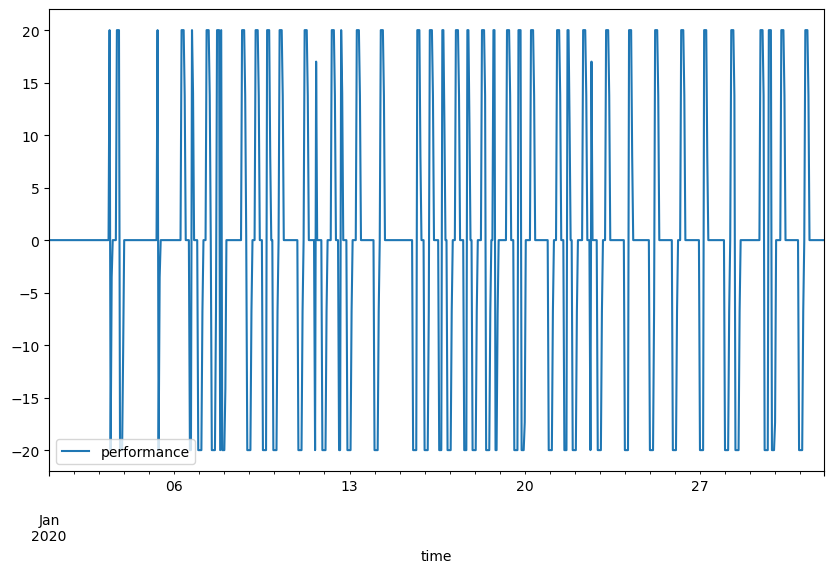

In [141]:
storage_performance = simulation.unit_performance["StorageUnit"]
storage_performance
specific_performance = storage_performance.sel(energy_unit = 1)
specific_performance.to_dataframe(name = 'performance').reset_index()
#convert to dataframe
#plot the dataframe for just january
specific_performance = specific_performance.sel(time=slice("2020-01-01", "2020-01-31"))
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
specific_performance.to_dataframe(name = 'performance').reset_index().plot(x='time', y='performance', ax=ax)

The ProbabilisticSimulation object generates a net hourly capacity matrix, representing net system capacity in each Monte Carlo trial. We can access a copy of this matrix to analyze shortfalls.

In [135]:
# convert net hourly capacity matrix to pandas dataframe with risk hours only
shortfall_matrix_pd = simulation.net_hourly_capacity_matrix.where(lambda c: c < 0).to_pandas().T.dropna(how="all")
shortfall_matrix_pd

trial,0
time,
2020-01-03 17:00:00,-6218.721778
2020-01-03 18:00:00,-4199.896222
2020-01-03 19:00:00,-1132.381855
2020-01-05 08:00:00,-7664.136960
2020-01-06 07:00:00,-6814.356366
...,...
2020-12-30 21:00:00,-5527.071768
2020-12-31 17:00:00,-6066.552869
2020-12-31 18:00:00,-11936.479041



We can calculate hourly loss of load probability from the net hourly capacity matrix

In [136]:
# get loss of load probability
loss_of_load_prob = shortfall_matrix_pd.count(axis=1) / shortfall_matrix_pd.shape[1]

# show top 10 risk hours
loss_of_load_prob.sort_values(ascending=False)[:10]

time
2020-01-03 17:00:00    1.0
2020-08-26 14:00:00    1.0
2020-08-22 22:00:00    1.0
2020-08-22 23:00:00    1.0
2020-08-23 08:00:00    1.0
2020-08-23 09:00:00    1.0
2020-08-23 10:00:00    1.0
2020-08-23 11:00:00    1.0
2020-08-23 12:00:00    1.0
2020-08-23 13:00:00    1.0
dtype: float64

In [137]:
# show shortfalls in first 5 trials
shortfall_matrix_pd.loc[:,:5]

trial,0
time,
2020-01-03 17:00:00,-6218.721778
2020-01-03 18:00:00,-4199.896222
2020-01-03 19:00:00,-1132.381855
2020-01-05 08:00:00,-7664.136960
2020-01-06 07:00:00,-6814.356366
...,...
2020-12-30 21:00:00,-5527.071768
2020-12-31 17:00:00,-6066.552869
2020-12-31 18:00:00,-11936.479041


In [138]:
from assetra.metrics import ExpectedUnservedEnergy

# instantiate eue model
eue_model = ExpectedUnservedEnergy(simulation)
eue = eue_model.evaluate()

print("System EUE:", round(eue, 2), "MWh")

System EUE: 139638325.3 MWh


In [139]:
from assetra.metrics import LossOfLoadHours, LossOfLoadDays, LossOfLoadFrequency
import pandas as pd

adequacy = pd.Series(dtype=float)

for name, metric in [
    ("EUE (MWh)", ExpectedUnservedEnergy),
    ("LOLH (h)", LossOfLoadHours),
    ("LOLD (d)", LossOfLoadDays),
    ("LOLF (#)", LossOfLoadFrequency)
]:
    adequacy[name] = metric(simulation).evaluate()

# show results
adequacy.round(1)

EUE (MWh)    139638325.3
LOLH (h)          2825.0
LOLD (d)           236.0
LOLF (#)           270.0
dtype: float64

In [112]:
adequacy["Average Outage Duration (h)"] = adequacy["LOLH (h)"] / adequacy["LOLF (#)"]
adequacy["Average Shortfall (MW)"] = adequacy["EUE (MWh)"] / adequacy["LOLH (h)"]

# show results
adequacy.round(1)


/var/folders/zd/3zqsbnbn5lg29wjyl0df33l80000gn/T/ipykernel_77724/1454703037.py:1: RuntimeWarning: invalid value encountered in scalar divide
  adequacy["Average Outage Duration (h)"] = adequacy["LOLH (h)"] / adequacy["LOLF (#)"]
/var/folders/zd/3zqsbnbn5lg29wjyl0df33l80000gn/T/ipykernel_77724/1454703037.py:2: RuntimeWarning: invalid value encountered in scalar divide
  adequacy["Average Shortfall (MW)"] = adequacy["EUE (MWh)"] / adequacy["LOLH (h)"]


EUE (MWh)                     -0.0
LOLH (h)                       0.0
LOLD (d)                       0.0
LOLF (#)                       0.0
Average Outage Duration (h)    NaN
Average Shortfall (MW)         NaN
dtype: float64

Quantify resource contribution (ELCC)

Resource contribution is a typical extension of resource adequacy analysis. The assetra package implements effective load-carrying capability (ELCC) to quantify resource contribution. When we instantiate an EffectiveLoadCarryingCapability object, the base system will automatically be evaluated according to the ResourceAdequacyMetric type we provide. In the following example, we indicate that resource adequacy should be defined as EUE (e.g. rather than LOLH) by passing ExpectedUnservedEnergy (the class not an instance) as the last parameter to the ELCC instance.


In [96]:
builder = EnergySystemBuilder()

for _, generator in class_to_test_df.iterrows():
    storage_duration = generator["Nameplate Energy Capacity (MWh)"] / generator["Nameplate Capacity (MW)"]
    if storage_duration < 4:
        storage_class = '2'
    elif 4 <= storage_duration < 6:
        storage_class = '4'
    elif 6 <= storage_duration < 8:
        storage_class = '6'
    elif 8 <= storage_duration < 10:
        storage_class = '8'
    else:
        storage_class = '12'
        
    storage_unit = StorageUnit(
        id=unit_count,
        nameplate_capacity=generator["Nameplate Capacity (MW)"],
        charge_rate=generator["Nameplate Capacity (MW)"],
        discharge_rate=generator["Nameplate Capacity (MW)"],
        charge_capacity=generator["Nameplate Energy Capacity (MWh)"],
        roundtrip_efficiency=STORAGE_EFFICIENCY,
        storage_duration = generator["Nameplate Energy Capacity (MWh)"] / generator["Nameplate Capacity (MW)"],
        storage_class = storage_class   
    )
    unit_count += 1
    builder.add_unit(storage_unit)

    # add unit to energy system
additional_system = builder.build()

In [97]:
additional_system.system_capacity

355.29999999999995

In [98]:
from assetra.contribution import EffectiveLoadCarryingCapability
from assetra.simulation import ProbabilisticSimulation
from assetra.metrics import ExpectedUnservedEnergy

# initialize elcc model
elcc_model = EffectiveLoadCarryingCapability(
    energy_system,
    ProbabilisticSimulation(
        start_hour="2020-01-01 00:00:00",
        end_hour="2020-12-31 23:00:00",
        trial_size=10
    ),
    ExpectedUnservedEnergy
)


In [84]:
from assetra.system import EnergySystemBuilder
from assetra.units import StochasticUnit

# create additional system with 1MW solar plant in Los Angeles, CA
additional_solar_nameplate_capacity = 10
additional_solar_latitude = 37.5407
additional_solar_longitude = 77.4360
additional_solar_hourly_capacity = additional_solar_nameplate_capacity * get_merra_power_generation_solar_cf(
    additional_solar_latitude,
    additional_solar_longitude
)
additional_solar_hourly_forced_outage_rate = xr.ones_like(additional_solar_hourly_capacity) * 0.05

# add unit to new system
builder = EnergySystemBuilder()
builder.add_unit(
    StochasticUnit(
        id=9999,
        nameplate_capacity=additional_solar_nameplate_capacity,
        hourly_capacity=additional_solar_hourly_capacity,
        hourly_forced_outage_rate=additional_solar_hourly_forced_outage_rate,
        marginal_cost=0
    )
)

In [99]:
additional_system = builder.build()

In [105]:
simulation.unit_performance["StorageUnit"]

<xarray.DataArray (trial: 1, energy_unit: 2, time: 8784)> Size: 141kB
array([[[  0.        ,   0.        ,   0.        , ...,  -0.8       ,
          -0.8       ,  -0.42352941],
        [  0.        ,   0.        ,   0.        , ..., -20.        ,
         -20.        , -10.58823529]]])
Coordinates:
  * trial    (trial) int64 8B 0
  * time     (time) datetime64[ns] 70kB 2020-01-01 ... 2020-12-31T23:00:00
Dimensions without coordinates: energy_unit

In [100]:
elcc = elcc_model.evaluate(additional_system)
elcc_pct = elcc / additional_system.system_capacity * 100
elcc_pct

14.453125

In [101]:
energy_system.system_capacity

211542.99999999997

In [102]:
elcc
additional_system.system_capacity

355.29999999999995

In [71]:
elcc_pct

14.453125